In [ ]:
import pandas as pd
import xarray as xr
import numpy as np

df_pivot = pd.read_csv("../data/processed/tmax_diaria_por_estacion_5_45_-95_-65.csv", index_col=0, parse_dates=True)
coords_df = pd.read_csv("../data/processed/coordenadas_estaciones_5_45_-95_-65.csv", index_col=0)

df_pivot.columns = df_pivot.columns.astype(float)
coords_df.index = coords_df.index.astype(float)

common_ids = df_pivot.columns.intersection(coords_df.index)
df_pivot = df_pivot[common_ids]
coords_df = coords_df.loc[common_ids]

station_coords = coords_df[['lat', 'lon']].to_dict(orient='index')

ds_era5 = xr.open_dataset("../data/raw/era5_tmax_daily_2024.nc")  


In [16]:
station_id = df_pivot.columns[0]  

lat_est = coords_df.loc[station_id, 'lat']
lon_est = coords_df.loc[station_id, 'lon']

ds_point = ds_era5.sel(latitude=lat_est, longitude=lon_est, method='nearest')
era5_series = (ds_point['t2m'] - 273.15).to_series()
obs_series = df_pivot[station_id]

df_cmp = pd.DataFrame({
    'obs': obs_series,
    'era5': era5_series
}).dropna()

In [32]:
records = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    if obs_series.isna().all():
        continue

    if station_id not in coords_df.index:
        continue

    lat_est = coords_df.loc[station_id, 'lat']
    lon_est = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat_est, longitude=lon_est, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({
        'obs': obs_series,
        'era5': era5_series
    }).dropna()

    if not df_cmp.empty:
        df_cmp['station_id'] = station_id
        df_cmp['date'] = df_cmp.index
        records.append(df_cmp[['date', 'station_id', 'obs', 'era5']])


In [33]:
df_all = pd.concat(records, ignore_index=True)


In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr

correlations = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    if obs_series.isna().all():
        correlations.append(np.nan)
        continue

    if station_id not in coords_df.index:
        correlations.append(np.nan)
        continue

    lat_est = coords_df.loc[station_id, 'lat']
    lon_est = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat_est, longitude=lon_est, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({
        'obs': obs_series,
        'era5': era5_series
    }).dropna()

    if len(df_cmp) < 2:
        correlations.append(np.nan)
    else:
        corr, _ = pearsonr(df_cmp['obs'], df_cmp['era5'])
        correlations.append(corr)

coords_df['correlation'] = correlations


In [45]:

area = [45, -95, 5, -65]
lat_max, lon_min, lat_min, lon_max = area

/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_21575/2052167744.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', len(bounds)-1)


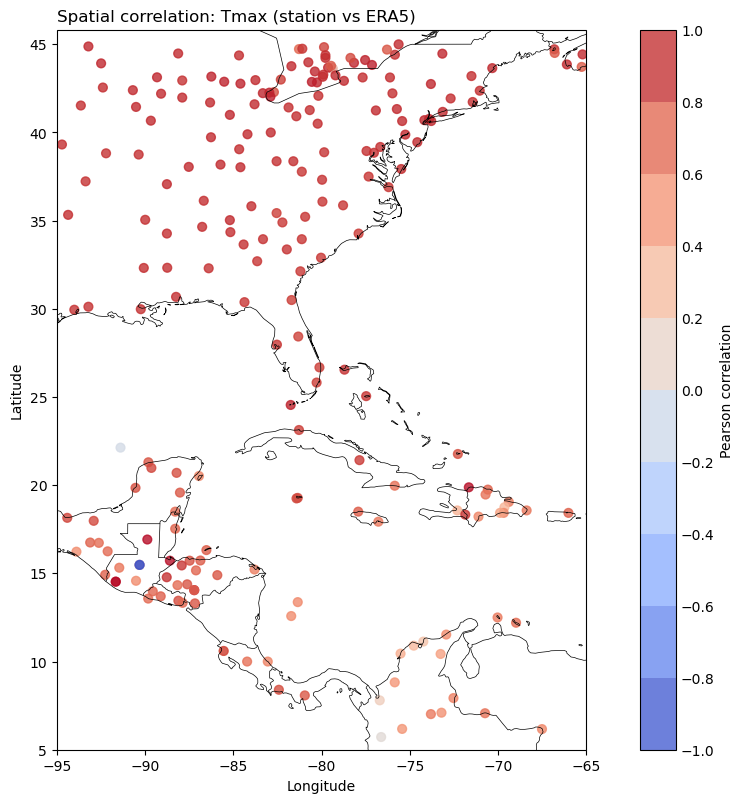

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

bounds = np.linspace(-1, 1, 11)  # 8 bins between -1 and 1
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cmap = plt.cm.get_cmap('RdBu_r', len(bounds)-1)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection=ccrs.PlateCarree())

coords_plot = coords_df.dropna(subset=['lat', 'lon', 'correlation'])

sc = ax.scatter(
    coords_plot['lon'], coords_plot['lat'],
    s=40,
    c=coords_plot['correlation'],
    cmap='coolwarm',
    vmin=-1, vmax=1,
    alpha=0.8,
    marker='o',
    edgecolors=None,
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

cb = plt.colorbar(sc, ax=ax, boundaries=bounds, ticks=bounds, label='Pearson correlation')
cb.ax.tick_params(length=0)  # optional: clean look

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial correlation: Tmax (station vs ERA5)', loc='left')
plt.show()


/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_21575/2749976852.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdBu_r', len(bounds)-1)


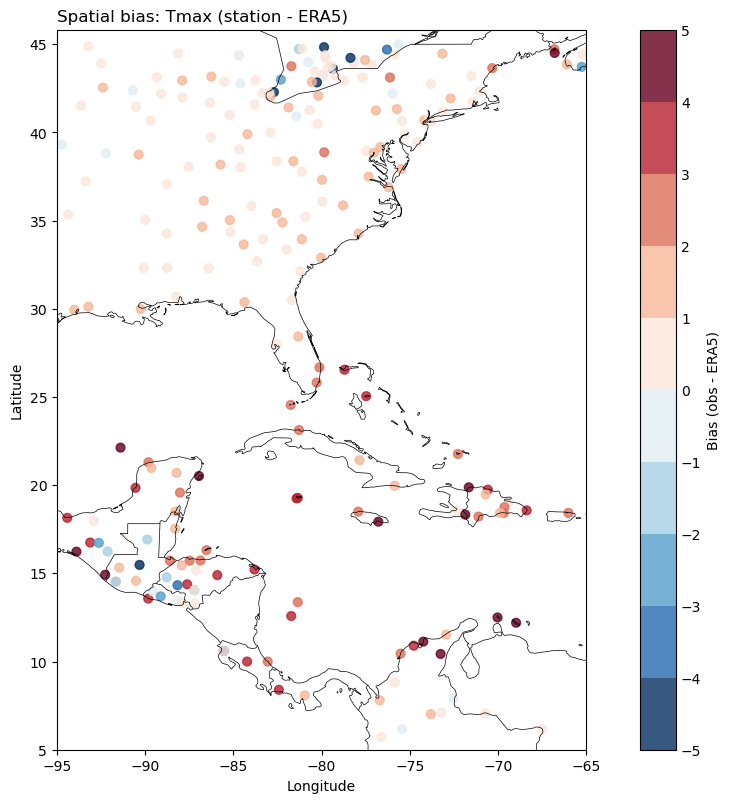

In [67]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

biases = []

for station_id in df_pivot.columns:
    obs_series = df_pivot[station_id]
    if obs_series.isna().all():
        biases.append(np.nan)
        continue

    if station_id not in coords_df.index:
        biases.append(np.nan)
        continue

    lat = coords_df.loc[station_id, 'lat']
    lon = coords_df.loc[station_id, 'lon']

    ds_point = ds_era5.sel(latitude=lat, longitude=lon, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({'obs': obs_series, 'era5': era5_series}).dropna()

    if len(df_cmp) < 2:
        biases.append(np.nan)
    else:
        bias = (df_cmp['obs'] - df_cmp['era5']).mean()
        biases.append(bias)

coords_df['bias'] = biases


bounds = np.linspace(-5, 5, 11)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cmap = plt.cm.get_cmap('RdBu_r', len(bounds)-1)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes([0.05, 0.05, 0.9, 0.9], projection=ccrs.PlateCarree())

coords_plot = coords_df.dropna(subset=['lat', 'lon', 'bias'])

sc = ax.scatter(
    coords_plot['lon'], coords_plot['lat'],
    s=40,
    c=coords_plot['bias'],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    marker='o',
    edgecolors=None,
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

cb = plt.colorbar(sc, ax=ax, boundaries=bounds, ticks=bounds, label='Bias (obs - ERA5)')
cb.ax.tick_params(length=0)

ax.set_title('Spatial bias: Tmax (station - ERA5)', loc='left')
plt.show()


<Axes: xlabel='obs', ylabel='era5'>

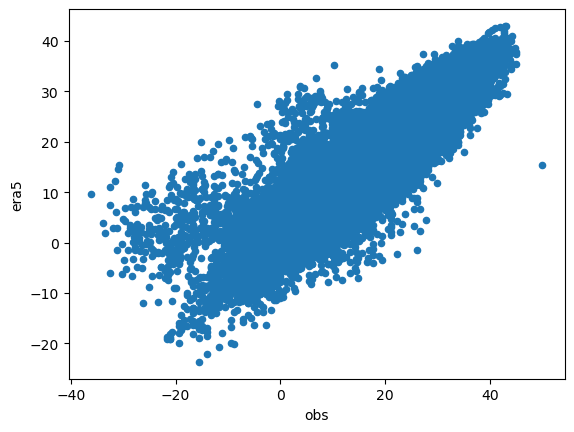

In [35]:
df_all.plot(x='obs', y='era5', kind='scatter')

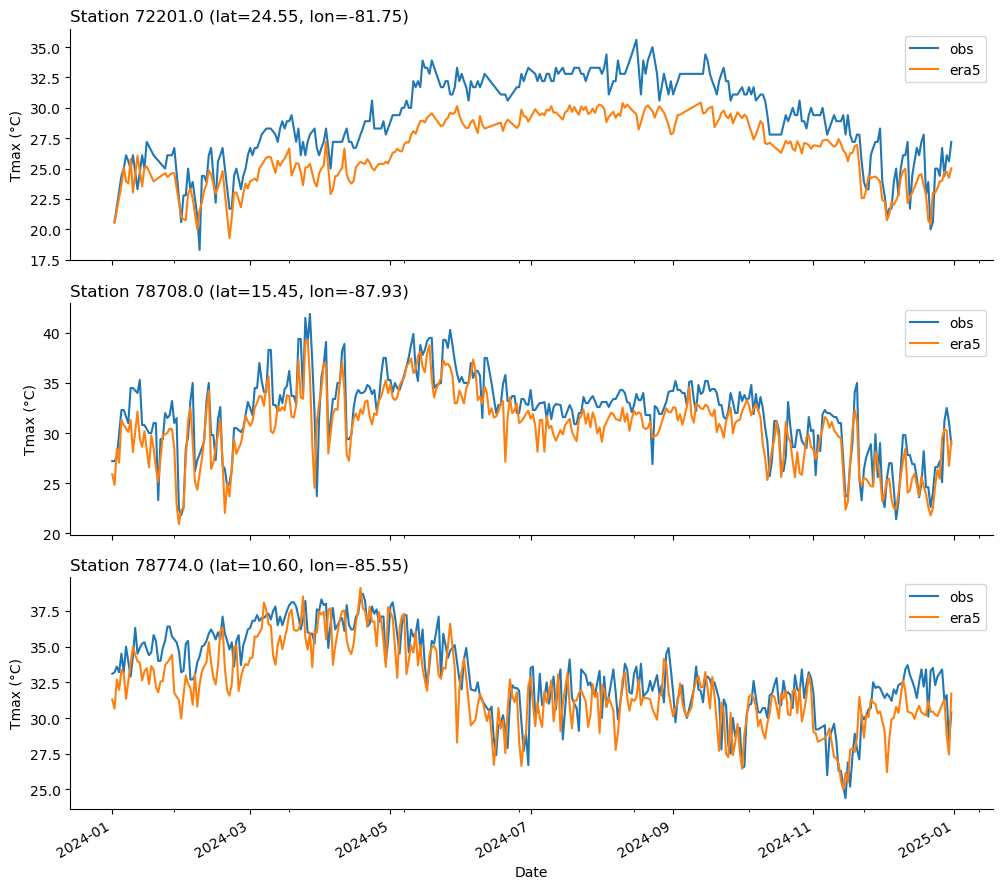

In [70]:

caribbean_df = coords_df[
    (coords_df['lat'] >= 10) & (coords_df['lat'] <= 25) &
    (coords_df['lon'] >= -90) & (coords_df['lon'] <= -60)
]

obs_counts = df_pivot.count()
caribbean_df = caribbean_df.join(obs_counts.rename("n_obs"))
caribbean_df = caribbean_df.dropna(subset=['correlation'])
caribbean_df = caribbean_df[caribbean_df['n_obs'] >= 300]

top_caribbean = caribbean_df.sort_values(by='correlation', ascending=False).head(3)
top_station_ids = top_caribbean.index.tolist()

fig, axes = plt.subplots(len(top_station_ids), 1, figsize=(10, 3 * len(top_station_ids)), sharex=True)

for ax, station_id in zip(axes, top_station_ids):
    lat = coords_df.loc[station_id, 'lat']
    lon = coords_df.loc[station_id, 'lon']
    obs_series = df_pivot[station_id]

    ds_point = ds_era5.sel(latitude=lat, longitude=lon, method='nearest')
    era5_series = (ds_point['t2m'] - 273.15).to_series()

    df_cmp = pd.DataFrame({
        'obs': obs_series,
        'era5': era5_series
    }).dropna()

    df_cmp.plot(ax=ax, ylabel="Tmax (°C)")
    ax.set_title(f"Station {station_id} (lat={lat:.2f}, lon={lon:.2f})", loc='left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.xlabel("Date")
plt.tight_layout()
plt.show()
